In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import seaborn as sns


In [19]:
df = pd.read_excel("/content/GICS.xlsx", parse_dates=['Date'])
df.set_index('Date', inplace=True)
df.head()

,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate,sp500,wti_spot,VIX,FedFunds,inflation_yoy,UNRATE,INDPRO
Date,,,,,,,,,,,,,,,,,,
2005-01-07,279.00,137.31,318.82,177.15,282.06,271.24,237.46,345.72,404.77,126.39,115.03,1186.19,44.07,13.49,2.14,0.028449,5.3,95.8785
2005-01-14,288.84,139.93,316.34,178.17,280.46,272.62,238.60,344.68,400.20,122.03,114.63,1184.52,46.79,12.43,2.25,0.028449,5.3,95.8785
2005-01-21,287.36,139.53,307.49,175.74,275.18,266.17,237.98,340.69,396.96,120.75,115.50,1167.87,47.85,14.36,2.28,0.028449,5.3,95.8785
2005-01-28,293.39,142.75,308.91,175.57,278.66,264.30,239.43,338.96,396.53,119.34,111.19,1171.36,48.56,13.24,2.27,0.028449,5.3,95.8785
2005-02-04,311.19,147.91,316.27,181.67,283.76,269.95,243.74,345.94,408.69,123.30,115.11,1203.03,46.97,11.21,2.43,0.030530,5.4,96.5709


In [24]:
duplicate_indices = df.index[df.index.duplicated(keep=False)]
if not duplicate_indices.empty:
    print(f"Warning: Duplicate dates found in index: {duplicate_indices.unique()}")
    # Option 1: Keep the first occurrence of each duplicate date
    df = df[~df.index.duplicated(keep='first')]
    print("Duplicate dates removed, keeping the first occurrence.")

## **log returns**

In [25]:
returns = np.log(df.iloc[:, :12] / df.iloc[:, :12].shift(1)).dropna()
returns['oil_return'] = np.log(df['wti_spot'] / df['wti_spot'].shift(1))
returns['VIX'] = df['VIX']
returns['FedFunds'] = df['FedFunds']
returns['inflation'] = df['inflation_yoy']
returns['UNRATE'] = df['UNRATE']
returns['INDPRO'] = df['INDPRO']
returns.dropna(inplace=True)
returns.head()

,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate,sp500,oil_return,VIX,FedFunds,inflation,UNRATE,INDPRO
Date,,,,,,,,,,,,,,,,,,
2005-01-14,0.034661,0.018901,-0.007809,0.005741,-0.005689,0.005075,0.004789,-0.003013,-0.011355,-0.035105,-0.003483,-0.001409,0.059890,12.43,2.25,0.028449,5.3,95.8785
2005-01-21,-0.005137,-0.002863,-0.028375,-0.013733,-0.019006,-0.023944,-0.002602,-0.011643,-0.008129,-0.010545,0.007561,-0.014156,0.022402,14.36,2.28,0.028449,5.3,95.8785
2005-01-28,0.020767,0.022815,0.004607,-0.000968,0.012567,-0.007050,0.006074,-0.005091,-0.001084,-0.011746,-0.038030,0.002984,0.014729,13.24,2.27,0.028449,5.3,95.8785
2005-02-04,0.058901,0.035509,0.023546,0.034154,0.018136,0.021152,0.017841,0.020383,0.030205,0.032644,0.034648,0.026678,-0.033291,11.21,2.43,0.030530,5.4,96.5709
2005-02-11,0.025853,-0.004472,-0.002184,0.006584,0.005588,-0.001372,-0.008239,0.003780,0.003639,-0.022888,0.020976,0.001885,-0.019130,11.43,2.50,0.030530,5.4,96.5709


In [31]:
results_by_window = {}

for window in [26, 52, 104]:
    print(f"Estimating oil betas using rolling window of {window} weeks")
    controls = ['VIX', 'FedFunds', 'inflation', 'UNRATE', 'INDPRO']
    oil_beta_dict = {}

    sectors = df.columns[:11]

    for sector in sectors:
        beta_list = []
        dates = []
        for t in range(window, len(returns)):
            y = returns[sector].iloc[t-window:t]
            X = returns[['oil_return'] + controls].iloc[t-window:t]
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            beta_list.append(model.params['oil_return'])
            dates.append(returns.index[t])

        oil_beta_dict[sector] = pd.Series(beta_list, index=dates)

    oil_betas = pd.DataFrame(oil_beta_dict)
    results_by_window[window] = oil_betas

for window, results in results_by_window.items():
    print(f"\nOil Betas for Rolling Window of {window} weeks:")
    display(results)
for window, results in results_by_window.items():
    print(f"\nSummary Statistics for Oil Betas (Rolling Window of {window} weeks):")
    display(results.describe())

Estimating oil betas using rolling window of 26 weeks
Estimating oil betas using rolling window of 52 weeks
Estimating oil betas using rolling window of 104 weeks

Summary Statistics for Oil Betas (Rolling Window of 26 weeks):


,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,0.333243,0.003748,-0.014088,0.073372,0.019919,-0.017383,-0.030651,-0.046207,0.016076,0.010146,-0.013729
std,0.219201,0.134162,0.184525,0.194927,0.170380,0.176404,0.125597,0.140316,0.252858,0.183803,0.236282
min,-0.231043,-0.482844,-0.671094,-0.423424,-0.454462,-0.535037,-0.378186,-0.383579,-0.726143,-0.627475,-0.650413
25%,0.193833,-0.073567,-0.131078,-0.043014,-0.096107,-0.128347,-0.112635,-0.144518,-0.124677,-0.089864,-0.144273
50%,0.290857,0.000796,-0.016465,0.046439,0.005861,-0.023117,-0.031560,-0.050198,0.000737,0.012694,-0.026412
75%,0.466517,0.091944,0.090947,0.186460,0.112684,0.092546,0.032097,0.022658,0.156182,0.123826,0.084086
max,1.200939,0.763461,0.650633,0.718327,0.544218,0.488974,0.622960,0.503248,0.772051,0.539918,0.913618



Summary Statistics for Oil Betas (Rolling Window of 52 weeks):


,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.319686,0.006105,0.002093,0.080792,0.031999,-0.002066,-0.023631,-0.039912,0.032856,0.015535,-0.013721
std,0.167168,0.086471,0.148970,0.150848,0.124960,0.135216,0.081830,0.100214,0.197335,0.119813,0.172633
min,-0.041365,-0.276596,-0.332033,-0.249220,-0.282577,-0.427002,-0.213999,-0.283413,-0.611449,-0.309319,-0.549262
25%,0.211168,-0.050634,-0.117979,-0.021924,-0.053020,-0.094915,-0.096484,-0.112813,-0.077829,-0.062873,-0.103481
50%,0.284394,0.002928,0.006373,0.060080,0.022078,-0.001311,-0.009976,-0.046784,0.026075,0.011962,-0.014391
75%,0.436851,0.062446,0.109671,0.172167,0.100607,0.080367,0.023072,0.023925,0.136392,0.095606,0.052309
max,0.889868,0.359679,0.368578,0.502055,0.419531,0.357567,0.266662,0.309008,0.552857,0.386097,0.608001



Summary Statistics for Oil Betas (Rolling Window of 104 weeks):


,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate
count,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000
mean,0.303042,0.014250,0.028892,0.102767,0.057022,0.020369,-0.011082,-0.023257,0.066315,0.026106,0.004627
std,0.147432,0.074931,0.126352,0.130485,0.102237,0.115941,0.063272,0.080948,0.157247,0.078968,0.131253
min,0.015519,-0.189577,-0.213509,-0.147212,-0.187788,-0.264647,-0.137258,-0.197569,-0.367058,-0.138369,-0.346083
25%,0.232784,-0.023085,-0.078455,0.012636,-0.003429,-0.051234,-0.072225,-0.078168,-0.003863,-0.025183,-0.067082
50%,0.279906,0.006195,0.009771,0.074680,0.048551,0.021921,0.005394,-0.032180,0.046108,0.025153,0.000564
75%,0.436767,0.080422,0.128504,0.201468,0.115002,0.104378,0.026617,0.012686,0.154780,0.084874,0.065254
max,0.593117,0.198003,0.308079,0.460092,0.328169,0.284626,0.128200,0.173187,0.447610,0.255806,0.327967


In [32]:
summary_stats_by_window = {}

for window, oil_betas in results_by_window.items():
    summary_df = pd.DataFrame({
        'Mean': oil_betas.mean(),
        'Std Dev': oil_betas.std(),
        'Min': oil_betas.min(),
        'Max': oil_betas.max(),
        'Skewness': oil_betas.skew(),
        'Kurtosis': oil_betas.kurt(),
        'Trend (Slope)': oil_betas.apply(lambda x: np.polyfit(range(len(x.dropna())), x.dropna(), 1)[0])
    })
    summary_stats_by_window[window] = summary_df
    print(f"\n📊 Summary Statistics for Rolling Window of {window} weeks:")
    display(summary_df.round(4))



📊 Summary Statistics for Rolling Window of 26 weeks:


,Mean,Std Dev,Min,Max,Skewness,Kurtosis,Trend (Slope)
Energy,0.3332,0.2192,-0.2310,1.2009,0.5393,0.2853,0.0002
Utilities,0.0037,0.1342,-0.4828,0.7635,0.1117,2.3699,-0.0000
IT,-0.0141,0.1845,-0.6711,0.6506,0.1332,0.8894,-0.0001
Materials,0.0734,0.1949,-0.4234,0.7183,0.4402,0.0944,-0.0001
Industrials,0.0199,0.1704,-0.4545,0.5442,0.3748,0.3547,0.0000
ConsumerDiscretionary,-0.0174,0.1764,-0.5350,0.4890,0.0749,0.0157,0.0000
ConsumerStaples,-0.0307,0.1256,-0.3782,0.6230,0.9091,2.7063,0.0000
healthcare,-0.0462,0.1403,-0.3836,0.5032,0.7019,1.1473,0.0000
Financials,0.0161,0.2529,-0.7261,0.7721,0.1145,0.6872,0.0001
CommunicationServices,0.0101,0.1838,-0.6275,0.5399,-0.2508,0.2348,0.0001



📊 Summary Statistics for Rolling Window of 52 weeks:


,Mean,Std Dev,Min,Max,Skewness,Kurtosis,Trend (Slope)
Energy,0.3197,0.1672,-0.0414,0.8899,0.4721,0.1560,0.0001
Utilities,0.0061,0.0865,-0.2766,0.3597,0.1431,0.5945,-0.0001
IT,0.0021,0.1490,-0.3320,0.3686,0.2660,-0.6498,-0.0001
Materials,0.0808,0.1508,-0.2492,0.5021,0.4982,-0.1974,-0.0001
Industrials,0.0320,0.1250,-0.2826,0.4195,0.3847,-0.0402,-0.0000
ConsumerDiscretionary,-0.0021,0.1352,-0.4270,0.3576,-0.1148,0.0444,-0.0000
ConsumerStaples,-0.0236,0.0818,-0.2140,0.2667,0.4241,0.3601,-0.0000
healthcare,-0.0399,0.1002,-0.2834,0.3090,0.4778,0.1767,-0.0000
Financials,0.0329,0.1973,-0.6114,0.5529,-0.3120,1.2125,0.0000
CommunicationServices,0.0155,0.1198,-0.3093,0.3861,-0.0652,0.0649,0.0000



📊 Summary Statistics for Rolling Window of 104 weeks:


,Mean,Std Dev,Min,Max,Skewness,Kurtosis,Trend (Slope)
Energy,0.3030,0.1474,0.0155,0.5931,-0.0875,-0.3195,0.0000
Utilities,0.0143,0.0749,-0.1896,0.1980,-0.3429,0.0594,-0.0001
IT,0.0289,0.1264,-0.2135,0.3081,0.1787,-0.9364,-0.0002
Materials,0.1028,0.1305,-0.1472,0.4601,0.5844,-0.4262,-0.0002
Industrials,0.0570,0.1022,-0.1878,0.3282,0.2318,0.0194,-0.0001
ConsumerDiscretionary,0.0204,0.1159,-0.2646,0.2846,-0.1686,-0.4892,-0.0001
ConsumerStaples,-0.0111,0.0633,-0.1373,0.1282,-0.0314,-0.8262,-0.0001
healthcare,-0.0233,0.0809,-0.1976,0.1732,0.5380,-0.1757,-0.0000
Financials,0.0663,0.1572,-0.3671,0.4476,-0.1044,0.1036,-0.0001
CommunicationServices,0.0261,0.0790,-0.1384,0.2558,-0.0870,-0.5843,-0.0001


## **Box plots**

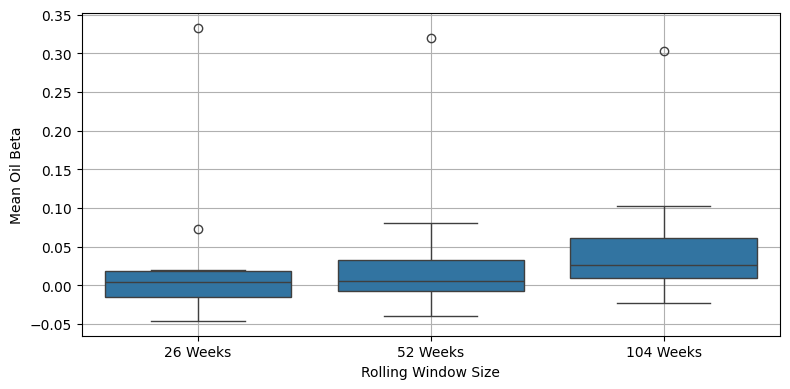

In [37]:
summary_stats = {
    "26 Weeks": {
        "Energy": 0.3332, "Utilities": 0.0037, "IT": -0.0141, "Materials": 0.0734,
        "Industrials": 0.0199, "ConsumerDiscretionary": -0.0174, "ConsumerStaples": -0.0307,
        "healthcare": -0.0462, "Financials": 0.0161, "CommunicationServices": 0.0101, "RealEstate": -0.0137
    },
    "52 Weeks": {
        "Energy": 0.3197, "Utilities": 0.0061, "IT": 0.0021, "Materials": 0.0808,
        "Industrials": 0.0320, "ConsumerDiscretionary": -0.0021, "ConsumerStaples": -0.0236,
        "healthcare": -0.0399, "Financials": 0.0329, "CommunicationServices": 0.0155, "RealEstate": -0.0137
    },
    "104 Weeks": {
        "Energy": 0.3030, "Utilities": 0.0143, "IT": 0.0289, "Materials": 0.1028,
        "Industrials": 0.0570, "ConsumerDiscretionary": 0.0204, "ConsumerStaples": -0.0111,
        "healthcare": -0.0233, "Financials": 0.0663, "CommunicationServices": 0.0261, "RealEstate": 0.0046
    }
}

data = []
for window, sectors in summary_stats.items():
    for sector, beta in sectors.items():
        data.append({"Window": window, "Sector": sector, "Oil Beta": beta})

df_box = pd.DataFrame(data)

plt.figure(figsize=(8, 4))
sns.boxplot(x="Window", y="Oil Beta", data=df_box)
plt.title("Distribution of Sectoral Oil Betas Across Rolling Windows")
plt.ylabel("Mean Oil Beta")
plt.xlabel("Rolling Window Size")
plt.grid()
plt.tight_layout()
plt.show()


## **Kalman Filter**

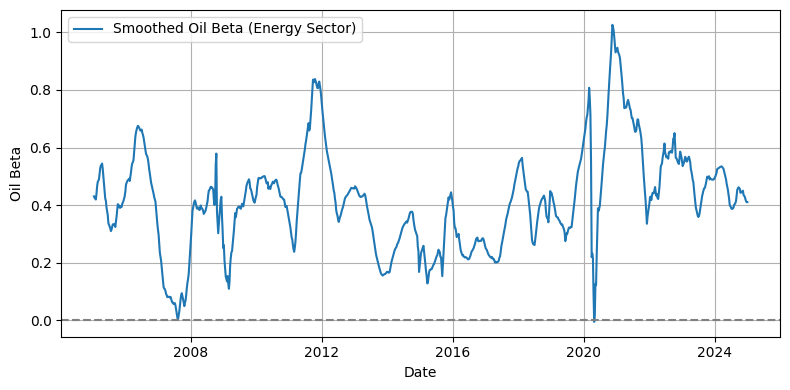

In [50]:
y = returns['Energy'].values
oil_return = returns['oil_return'].values.reshape(1, 1, -1)
exog_controls = returns[['VIX', 'FedFunds', 'inflation', 'UNRATE', 'INDPRO']].values

# state space model
class TVOilBetaModel(MLEModel):
    def __init__(self, endog, oil_design, controls):
        k_states = 1
        super().__init__(endog, k_states=k_states, exog=controls, initialization='approximate_diffuse')
        self.ssm['design'] = oil_design
        self.ssm['transition'] = np.eye(k_states)
        self.ssm['selection'] = np.eye(k_states)
        self.ssm['state_cov'] = np.eye(k_states) * 0.01

    def update(self, params, **kwargs):
        self.ssm['obs_cov', 0, 0] = params[0]

    @property
    def start_params(self):
        return [0.1]

model = TVOilBetaModel(y, oil_return, exog_controls)
res = model.fit(disp=False)

smoothed_state = res.smoothed_state[0]
plt.figure(figsize=(8, 4))
plt.plot(returns.index, smoothed_state, label='Smoothed Oil Beta (Energy Sector)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Oil Beta')
plt.title('Kalman Filter Estimate of Time-Varying Oil Beta (Energy Sector)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
smoothed_beta = res.smoothed_state[0]

# descriptive statistics
mean_beta = np.mean(smoothed_beta)
std_beta = np.std(smoothed_beta)
min_beta = np.min(smoothed_beta)
max_beta = np.max(smoothed_beta)
skew_beta = pd.Series(smoothed_beta).skew()
kurt_beta = pd.Series(smoothed_beta).kurt()

print("Time-Varying Beta Descriptive Statistics:")
print(f"  Mean: {mean_beta:.4f}")
print(f"  Std Dev: {std_beta:.4f}")
print(f"  Min: {min_beta:.4f}")
print(f"  Max: {max_beta:.4f}")
print(f"  Skewness: {skew_beta:.4f}")
print(f"  Kurtosis: {kurt_beta:.4f}")

# parameters
estimated_params = res.params
obs_cov = estimated_params[0]

print("\nEstimated Model Parameters:")
print(f"  Observation Covariance (H): {obs_cov:.4f}")
print(f"  State Covariance (Q): {model.ssm['state_cov', 0, 0]:.4f}")

Time-Varying Beta Descriptive Statistics:
  Mean: 0.4155
  Std Dev: 0.1760
  Min: -0.0053
  Max: 1.0260
  Skewness: 0.4658
  Kurtosis: 0.6589

Estimated Model Parameters:
  Observation Covariance (H): 0.0010
  State Covariance (Q): 0.0100
